In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("./rlearn.mplstyle")

import pickle

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
from pathos.multiprocessing import Pool

import pynumtools.kmc as kmc

from readdy_learn.example.regulation_network import RegulationNetwork
from readdy_learn.example.regulation_network import sample_lsq_rates
from readdy_learn.example.regulation_network import sample_along_alpha

import case_config

In [2]:
DATA_ROOT = "/home/mho/Dropbox/phd/readdy_learn/reaction_learn_data"
PICKLE_FILE = "case1_data/case_1_more_bfc_dt_3e-3_tt_2.pickle"

In [3]:
case_config.print_config(False)

ReaDDy learn config
*********************************************
Target time: 2.0
Gillespie intermediate rescaling factor: 500.0
Discretization timestep: 0.003


In [4]:
case_config.INITIAL_CONDITIONS

[[1, 2, 0, 1, 0, 3, 1, 0, 0], [1, 1.5, 0, 1, 0, 2.0, 1, 0, 1.0]]

In [5]:
def plot_l1_errors(regulation_network, results, cutoff=0.):
    l1_errors = []
    l1_std = []
    keys_sorted = np.array([k for k in sorted(results.keys())])
    for key in keys_sorted:
        # shape: (n_realizations, basis funs)
        rates = np.array(results[key])
        # build difference w correct rates
        ratesdiff = np.abs(np.array([r - regulation_network.desired_rates for r in rates]))
        l1norms = np.array([np.sum(x) for x in ratesdiff])
        l1_errors.append(np.mean(l1norms))
        l1_std.append(np.std(l1norms))
    l1_errors = np.array(l1_errors)
    l1_std = np.array(l1_std)
    plt.fill_between(keys_sorted, l1_errors-l1_std, l1_errors+l1_std,
                     color='b', alpha=.5)
    #plt.errorbar(keys, l2_mean, yerr=l2_std)
    plt.plot(keys_sorted, l1_errors)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('L1 error')
    ix = np.argmin(l1_errors)
    return l1_errors[ix], ix
def do(alphas):
    regulation_network, analysis = case_config.get_regulation_network_lma()
    if alphas is None:
        alphas = np.logspace(-6, -4, num=200)
    result = sample_along_alpha(regulation_network, alphas=alphas)
    lsq_rates = analysis.least_squares(0, tol=1e-16, recompute=True, persist=False, verbose=False)
    ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
    plt.title('LSQ')
    plt.show()
    error, ix = plot_l1_errors(regulation_network, result)
    plt.show()
    ana.plot_rates_bar(regulation_network.desired_rates, np.array(result[alphas[ix]]).squeeze())
    plt.title('regularized')
    plt.show()
    
    data = {
        'regularized_rates': result,
        'lsq_rates': lsq_rates
    }
    
    print("minimal l1 error: {} (ix {}, alpha {})".format(error, ix, alphas[ix]))
    with open(PICKLE_FILE, 'wb') as f:
        pickle.dump(data, f)
    print("saved pickle file to {}".format(f))
def load_results():
    with open(PICKLE_FILE, 'rb') as f:
        return pickle.load(f)
def show_results(alphas=None):
    print("loading results from {}....".format(PICKLE_FILE))
    regulation_network, analysis = case_config.get_regulation_network_lma()
    if alphas is None:
        alphas = np.logspace(-6, -4, num=200)
    
    with open(PICKLE_FILE, 'rb') as f:
        data = pickle.load(f)
    
    result = data['regularized_rates']
    lsq_rates = data['lsq_rates']
    
    ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
    plt.title('LSQ')
    plt.show()
    error, ix = plot_l1_errors(regulation_network, result)
    plt.show()
    ana.plot_rates_bar(regulation_network.desired_rates, np.array(result[alphas[ix]]).squeeze())
    plt.title('regularized')
    plt.show()
    print("minimal l1 error: {} (ix {}, alpha {})".format(error, ix, alphas[ix]))
def do_or_dont(alphas=None):
    print("checking if \"{}\" exists".format(PICKLE_FILE))
    if os.path.exists(PICKLE_FILE):
        show_results(alphas)
    else:
        do(alphas)

checking if "case1_data/case_1_more_bfc_dt_3e-3_tt_2.pickle" exists
loading results from case1_data/case_1_more_bfc_dt_3e-3_tt_2.pickle....
47
47
n_frames=667, n_species=9


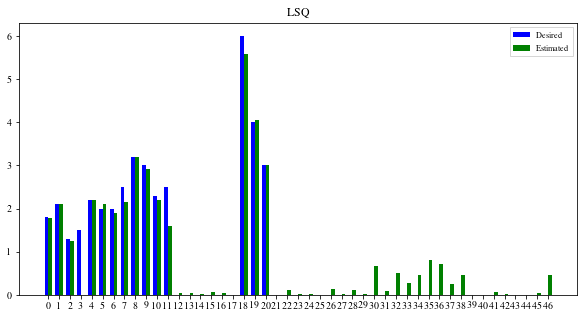

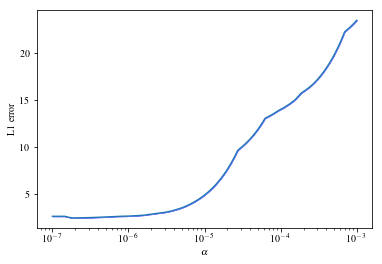

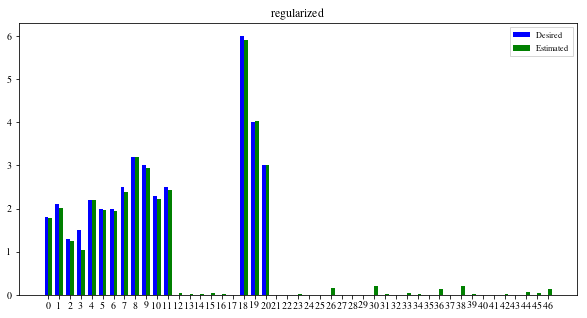

minimal l1 error: 2.4077475813223574 (ix 14, alpha 1.9116440753857036e-07)


In [6]:
do_or_dont(np.logspace(-7, -3, num=200))

In [7]:
results = load_results()
lsq = results['lsq_rates']
reg = results['regularized_rates'][list(results['regularized_rates'].keys())[14]][0]

In [8]:
def uniqueify(mylist):
    used = []
    unique = [x for x in mylist if x not in used and (used.append(x) or True)]
    return unique

In [9]:
from matplotlib.patches import Wedge
def half_circle_left(radius, color, angle=0, **kwargs):
    """
    Add two half circles to the axes *ax* (or the current axes) at the lower
    left corner of the axes with the specified facecolors *colors* rotated at
    *angle* (in degrees).
    """
    kwargs.update(transform=ax.transAxes, clip_on=False)
    center = (0, 0)
    theta1, theta2 = angle, angle + 180
    return Wedge(center, radius, theta1, theta2, fc=color, **kwargs)

def half_circle_right(radius, color, angle=0, **kwargs):
    """
    Add two half circles to the axes *ax* (or the current axes) at the lower
    left corner of the axes with the specified facecolors *colors* rotated at
    *angle* (in degrees).
    """
    kwargs.update(transform=ax.transAxes, clip_on=False)
    center = (0, 0)
    theta1, theta2 = angle, angle + 180
    return Wedge(center, radius, theta2, theta1, fc=color, **kwargs)

47
47
n_frames=667, n_species=9
found best cutoff value 0.2136867652097164, using 0.22


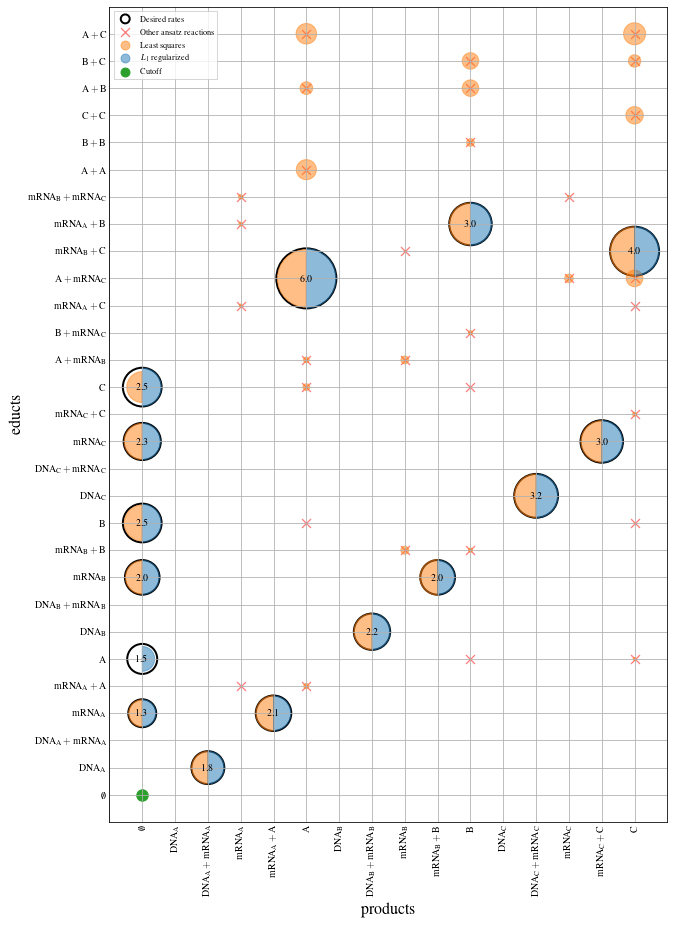

In [10]:
regulation_network = case_config.get_regulation_network_lma()[0]
bfc = regulation_network.get_bfc()
# axis names...
species_mapping = case_config.SPECIES_TEX
# collect possible educts and products
involved_species_and_pairs = [(-1,)]
for fun in bfc.functions:
    if isinstance(fun, basis.ConversionReaction):
        involved_species_and_pairs += [(fun.type1,), (fun.type2,)]
    elif isinstance(fun, basis.FusionReaction):
        involved_species_and_pairs += [sorted((fun.type_from1, fun.type_from2)), (fun.type_to,)]
    elif isinstance(fun, basis.FissionReaction):
        involved_species_and_pairs += [(fun.type_from,), sorted((fun.type_to1, fun.type_to2))]
    elif isinstance(fun, basis.DecayReaction):
        involved_species_and_pairs += [(fun.type_from,)]
    else:
        raise ValueError("unknown reaction type {}".format(fun))
involved_species_and_pairs = uniqueify(involved_species_and_pairs)

axlabels = []
for tup in involved_species_and_pairs:
    inner = [species_mapping[x] for x in tup]
    inner = " + ".join(inner)
    axlabels.append(r'${}$'.format(inner))
        
step = 2.
N = np.arange(0, step+step*len(axlabels), step)

Nx = N[:17]

fig, ax = plt.subplots(1,1, figsize=(10, 15))

ax.set_xlim(left=0, right=len(Nx)*step)
ax.set_xticks(step + Nx, minor=False)
ax.set_xticklabels(axlabels[:len(Nx)-1], rotation='vertical')
ax.set_xticks(Nx, minor=True)

ax.set_ylim(bottom=0, top=len(N)*step)
ax.set_yticks(step + N)
ax.set_yticklabels(axlabels)
ax.set_yticks(N, minor=True)

# hide ticks
ax.tick_params(which='both', axis='both', length=0, width=0)

ax.grid(which='minor')

desired_rates_matrix = np.zeros((len(axlabels), len(axlabels)))
lsq_rates_matrix = np.zeros_like(desired_rates_matrix)
regularized_rates_matrix = np.zeros_like(desired_rates_matrix)
reactions_matrix = np.zeros_like(desired_rates_matrix)
for idx, fun in enumerate(bfc.functions):
    if isinstance(fun, basis.ConversionReaction):
        ix1 = involved_species_and_pairs.index((fun.type1,))
        ix2 = involved_species_and_pairs.index((fun.type2,))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
        reactions_matrix[ix1, ix2] = 1.
    elif isinstance(fun, basis.FusionReaction):
        ix1 = involved_species_and_pairs.index(sorted((fun.type_from1, fun.type_from2)))
        ix2 = involved_species_and_pairs.index((fun.type_to,))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
        reactions_matrix[ix1, ix2] = 1.
    elif isinstance(fun, basis.FissionReaction):
        ix1 = involved_species_and_pairs.index((fun.type_from,))
        ix2 = involved_species_and_pairs.index(sorted((fun.type_to1, fun.type_to2)))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
        reactions_matrix[ix1, ix2] = 1.
    elif isinstance(fun, basis.DecayReaction):
        ix1 = involved_species_and_pairs.index((fun.type_from,))
        ix2 = 0
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
        reactions_matrix[ix1, ix2] = 1.
    else:
        raise ValueError("unknown reaction type {}".format(fun))
    lsq_rates_matrix[ix1, ix2] = lsq[idx]
    regularized_rates_matrix[ix1, ix2] = reg[idx]

scatter_lsq_x = []
scatter_lsq_y = []
scatter_lsq_s = []

scatter_lsq_shared_x = []
scatter_lsq_shared_y = []
scatter_lsq_shared_s = []

scatter_reg_x = []
scatter_reg_y = []
scatter_reg_s = []

scatter_reg_shared_x = []
scatter_reg_shared_y = []
scatter_reg_shared_s = []
    
scatter_x = []
scatter_y = []
scatter_s = []

scatter_undesired_reactions_x = []
scatter_undesired_reactions_y = []

best_cutoff = 0
for i in range(len(axlabels)):
    for j in range(len(axlabels)):
        if desired_rates_matrix[i, j] == 0 and regularized_rates_matrix[i, j] != 0:
            best_cutoff = max(best_cutoff, regularized_rates_matrix[i, j])

cutoff = .22 #best_cutoff
print("found best cutoff value {}, using {}".format(best_cutoff, cutoff))

for i in range(len(axlabels)):
    for j in range(len(axlabels)):
        if reactions_matrix[i, j] > 0 and desired_rates_matrix[i, j] == 0.:
            scatter_undesired_reactions_x.append(i)
            scatter_undesired_reactions_y.append(j)
        if lsq_rates_matrix[i, j] > 0:
            if regularized_rates_matrix[i, j] > cutoff:
                scatter_lsq_shared_x.append(i)
                scatter_lsq_shared_y.append(j)
                scatter_lsq_shared_s.append(lsq_rates_matrix[i, j])
            else:
                scatter_lsq_x.append(i)
                scatter_lsq_y.append(j)
                scatter_lsq_s.append(lsq_rates_matrix[i, j])
        if regularized_rates_matrix[i, j] > cutoff:
            if lsq_rates_matrix[i, j] > 0:
                scatter_reg_shared_x.append(i)
                scatter_reg_shared_y.append(j)
                scatter_reg_shared_s.append(regularized_rates_matrix[i, j])
            else:
                scatter_reg_x.append(i)
                scatter_reg_y.append(j)
                scatter_reg_s.append(regularized_rates_matrix[i, j])
        if desired_rates_matrix[i, j] > cutoff:
            scatter_x.append(i)
            scatter_y.append(j)
            scatter_s.append(desired_rates_matrix[i, j])
            
scale=600.

scatter_x = step + step*np.array(scatter_x)
scatter_y = step + step*np.array(scatter_y)
scatter_s = scale*np.array(scatter_s)
plt.scatter(scatter_y, scatter_x, s=scatter_s, 
            edgecolors='k', facecolors='none', label='Desired rates', linewidths=2, marker='o')

scatter_undesired_reactions_x = step + step * np.array(scatter_undesired_reactions_x)
scatter_undesired_reactions_y = step + step * np.array(scatter_undesired_reactions_y)
plt.scatter(scatter_undesired_reactions_y, scatter_undesired_reactions_x, s=80., 
            edgecolors='k', facecolors='r', marker='x', alpha=.5, label='Other ansatz reactions')

scatter_lsq_x = step + step * np.array(scatter_lsq_x)            
scatter_lsq_y = step + step * np.array(scatter_lsq_y)            
scatter_lsq_s = scale*np.array(scatter_lsq_s)

scatter_lsq_shared_x = step + step * np.array(scatter_lsq_shared_x)            
scatter_lsq_shared_y = step + step * np.array(scatter_lsq_shared_y)            
scatter_lsq_shared_s = scale*np.array(scatter_lsq_shared_s)

lwedge = half_circle_left(1., 'C1', 90)
plt.scatter(scatter_lsq_y, scatter_lsq_x, s=scatter_lsq_s, alpha=.5, facecolors='C1', label='Least squares', 
            marker='o')
plt.scatter(scatter_lsq_shared_y, scatter_lsq_shared_x, s=scatter_lsq_shared_s, alpha=.5, facecolors='C1', 
            marker=lwedge.get_path())

scatter_reg_x = step + step * np.array(scatter_reg_x)            
scatter_reg_y = step + step * np.array(scatter_reg_y)            
scatter_reg_s = scale*np.array(scatter_reg_s)

scatter_reg_shared_x = step + step * np.array(scatter_reg_shared_x)            
scatter_reg_shared_y = step + step * np.array(scatter_reg_shared_y)            
scatter_reg_shared_s = scale*np.array(scatter_reg_shared_s)

rwedge = half_circle_right(1., 'C0', 90)
plt.scatter(scatter_reg_y, scatter_reg_x, s=scatter_reg_s, edgecolors='C0', 
            facecolors='C0', label=r'$L_1$ regularized', linewidths=1, alpha=.5, marker='o')
plt.scatter(scatter_reg_shared_y, scatter_reg_shared_x, s=scatter_reg_shared_s, edgecolors='C0', 
            facecolors='C0', linewidths=1, alpha=.5, marker=rwedge.get_path())

plt.scatter([step], [step], s=scale*cutoff, edgecolors='C2', facecolors='C2', label='Cutoff')

ix = 0
for i in range(len(axlabels)):
    for j in range(len(axlabels)):
        if desired_rates_matrix[i, j] != 0:
            ax.annotate('{}'.format(desired_rates_matrix[i, j]), 
                        xy=(scatter_y[ix], scatter_x[ix]),
                        horizontalalignment='center', verticalalignment='center')
            ix += 1
        

lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle._sizes = [80]
    
ax.set_xlabel('products', fontsize=16)
ax.set_ylabel('educts', fontsize=16)
# ax.set_title('sparsity pattern for cutoff {}'.format(cutoff))
plt.savefig('sparsity_pattern.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [11]:
plt.style.use("./rlearn.mplstyle")

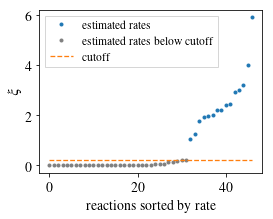

In [12]:
f, ax = plt.subplots(1, 1)
sorted_rates = np.sort(reg)
xs = np.arange(len(sorted_rates))
mask_rates = sorted_rates > cutoff
ax.plot(xs[mask_rates], sorted_rates[mask_rates], '.', label='estimated rates')
ax.plot(xs[~mask_rates], sorted_rates[~mask_rates], '.', color='grey', label='estimated rates below cutoff')
ax.plot([cutoff]*len(reg), '--', label='cutoff')
ax.set_ylabel(r"$\xi$")
ax.set_xlabel('reactions sorted by rate')
ax.legend()
f.savefig("case1_cutoff.pdf", bbox_inches="tight", transparent=True)

In [14]:
traj = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_init_1.h5"), 20000, 2)

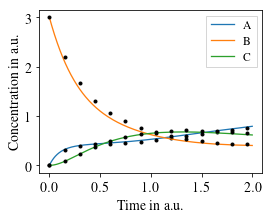

In [31]:
estimated_rates = lsq[:]
estimated_rates[np.where(estimated_rates < cutoff)] = 0
xs, ys = case_config.integrate(case_config.INITIAL_CONDITIONS[0], estimated_rates)

#species = np.array([1, 2, 4, 5, 7, 8])
species = np.array([2, 5, 8])
t = np.arange(len(traj[0]))*case_config.TIMESTEP
stride=50
for s in species:
    name = case_config.SPECIES_TEX[s]
    plt.plot(t, traj[0][:,s], label=r"${}$".format(name))
    plt.plot(xs[::stride], ys[:, s][::stride], 'k.')
plt.legend()
plt.xlabel('Time in a.u.')
plt.ylabel('Concentration in a.u.')
plt.savefig('case1_lsq_trajectory.pdf', bbox_inches='tight', transparent=True)

In [10]:
traj = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_init_1.h5"), 20000, 2)

Text(0,0.5,'Concentration in a.u.')

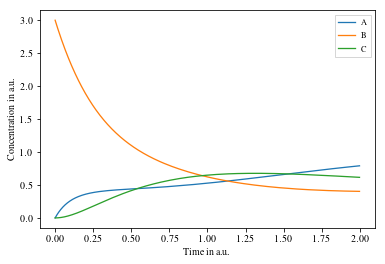

In [14]:
estimated_rates = reg[:]
estimated_rates[np.where(estimated_rates < cutoff)] = 0
xs, ys = case_config.integrate(case_config.INITIAL_CONDITIONS[0], estimated_rates)

#species = np.array([1, 2, 4, 5, 7, 8])
species = np.array([2, 5, 8])
t = np.arange(len(traj[0]))*case_config.TIMESTEP
for s in species:
    name = case_config.SPECIES_TEX[s]
    plt.plot(t, traj[0][:,s], label=r"${}$".format(name))
    # plt.plot(xs, ys[:, s], '--')
plt.legend()
plt.xlabel('Time in a.u.')
plt.ylabel('Concentration in a.u.')